In [1]:
# imports
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# this allows plots to appear directly in the notebook
%matplotlib inline

limit = 100000000

/home/ilya/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/home/ilya/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [65]:
# read in data
sold = pd.read_csv('../CSV_backups/ALL-sales.csv',nrows=limit, index_col=['property_id','transaction_id']).drop_duplicates()

/home/ilya/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,13,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
# only show properties that were actually sold (and a check to exclude those with wrong close dates e.g. >10000 days)
df = sold[(sold.date_closed > 1400) & (sold.date_closed < 10000) & (sold.year_built != 0) & (sold.elevation !=0) & (sold.bathrooms != 0)] \
        [["address","zipcode","latitude","longitude", "date_closed","price","sqft","bedrooms","bathrooms", "year_built", "dist_to_park","elevation","has_pool"]]
df.rename(columns = {'date_closed':'date'}, inplace = True)

# convert days since Y2K to a nice looking date
df['date'] = df['date'].apply(lambda x: dt.date(2000, 1, 1) + dt.timedelta(days=x)) \
                       .astype("datetime64[ns]")

df['age'] = (2018 - df['year_built']).astype("int64")
df['has_pool'] = df['has_pool'].astype("bool")
df['zipcode'] = df['zipcode'].astype("str")
df["year"] = df.date.dt.year.astype('int64')
df.drop(['year_built','date'], axis=1, inplace=True)
df['elevation'] = (df['elevation'] - df.elevation.median()).astype("int64")   
    
df['ppsf'] = (df.price / df.sqft)
df.head(6)

,,address,zipcode,latitude,longitude,price,sqft,bedrooms,bathrooms,dist_to_park,elevation,has_pool,age,year,ppf
property_id,transaction_id,,,,,,,,,,,,,,
346200,23951313,"8942 N 15th Ln, Phoenix, AZ 85021",85021,33.5674,-112.094,400000,2388,4,3,0.780000,8,True,3,2014,167.504188
9020277,23951289,"4350 W Shaw Butte Dr, Glendale, AZ 85304",85304,33.5954,-112.153,320000,2120,4,2,0.377359,11,False,1,2015,150.943396
336902,23951266,"2125 W State Ave, Phoenix, AZ 85021",85021,33.5442,-112.105,285000,1723,3,2,0.925419,-5,False,60,2018,165.409170
990354,23951257,"1455 W Remington Dr, Chandler, AZ 85286",85286,33.2849,-111.867,367000,2286,3,2,0.310000,0,False,20,2017,160.542432
9000471,23951250,"11774 E Mercer Ln, Scottsdale, AZ 85259",85259,33.5853,-111.827,369000,1502,3,2,0.980867,96,False,31,2018,245.672437
9035947,23951038,"1602 W Argon St, Mesa, AZ 85201",85201,33.4185,-111.866,150500,1512,3,2,1.352070,7,False,58,2005,99.537037


In [67]:
df.describe()

,latitude,longitude,price,sqft,bedrooms,bathrooms,dist_to_park,elevation,age,year,ppf
count,236957.000000,236957.000000,236957.000000,236957.000000,236957.000000,236957.000000,236957.000000,236957.000000,236957.000000,236957.000000,236957.000000
mean,33.533439,-112.093198,181559.938820,1626.808484,2.919188,1.969952,0.667473,3.525699,44.197331,2011.018738,113.883753
std,0.084254,0.111097,82679.168934,452.721221,1.160385,0.525189,0.485282,36.197367,17.906476,4.353770,48.229095
min,33.283200,-112.275000,50000.000000,500.000000,0.000000,1.000000,0.000000,-65.000000,0.000000,2003.000000,13.844051
25%,33.477600,-112.173000,119000.000000,1313.000000,3.000000,2.000000,0.304795,-23.000000,33.000000,2007.000000,78.903654
50%,33.534600,-112.113000,169900.000000,1570.000000,3.000000,2.000000,0.563560,0.000000,44.000000,2011.000000,109.102244
75%,33.601300,-112.031000,233000.000000,1870.000000,4.000000,2.000000,0.901998,20.000000,58.000000,2015.000000,143.149284
max,33.665300,-111.811000,400000.000000,4000.000000,6.000000,6.000000,3.199080,224.000000,357.000000,2018.000000,709.090909


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa430b2ccf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa409f9da90>]], dtype=object)

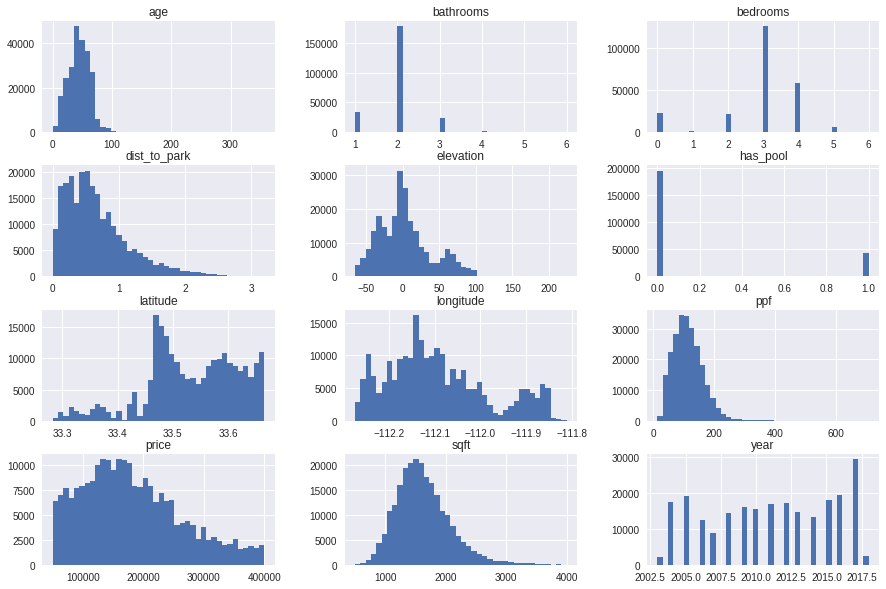

In [68]:
df.hist(bins=40,figsize=(15,10))

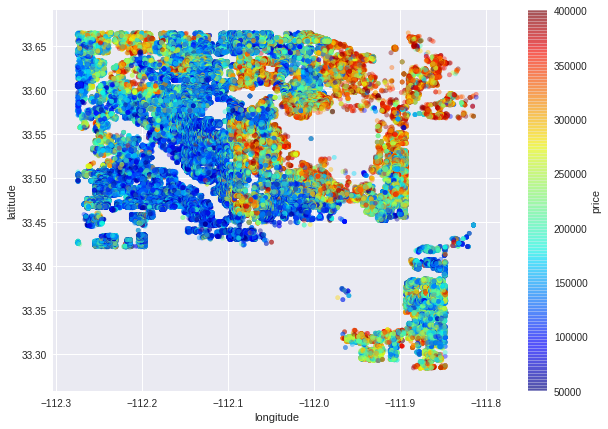

In [69]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), \
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,\
    sharex=False)

In [77]:
price_model = ols("price ~ C(year):sqft + C(zipcode):sqft + bedrooms + bathrooms + sqft:dist_to_park + sqft:elevation + sqft:age", data=df).fit()
# summarize our model
price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     4029.
Date:                Tue, 29 May 2018   Prob (F-statistic):               0.00
Time:                        21:38:42   Log-Likelihood:            -2.9045e+06
No. Observations:              236957   AIC:                         5.809e+06
Df Residuals:                  236860   BIC:                         5.810e+06
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 6.946e+04    501.827    138.410      0.000    6.85e+04    7.04e+04
C(year)[2003]:sqft         118.3643      1.249     94.732      0.000     115.915     120.813
C(year)[2004]:sqft         125.4896      1.106    113.496      0.000     123.322     127.657
C(year)[2005]:sqft         156.3076      1.109    140.944      0.000     154.134     158.481
C(year)[2006]:sqft         177.2809      1.127    157.237      0.000     175.071     179.491
C(year)[2007]:sqft         170.1736      1.140    149.315      0.000     167.940     172.407
C(year)[2008]:sqft         140.8716      1.118    125.991      0.000     138.680     143.063
C(year)[2009]:sqft         115.6599      1.109    104.266      0.000     113.486     117.834
C(year)[2010]:sqft         112.9949      1.109    101.896      0.000     110.821     115.168
C(year)[2011]:sqft         104.7918      1.105     94.831      0.000     102.626     106.958
C(year)[2012]:sqft         112.6219      1.106    101.788      0.000     110.453     114.790
C(year)[2013]:sqft         127.9207      1.113    114.909      0.000     125.739     130.103
C(year)[2014]:sqft         136.2153      1.116    122.044      0.000     134.028     138.403
C(year)[2015]:sqft         144.2314      1.106    130.446      0.000     142.064     146.399
C(year)[2016]:sqft         153.2358      1.106    138.523      0.000     151.068     155.404
C(year)[2017]:sqft         164.6686      1.102    149.372      0.000     162.508     166.829
C(year)[2018]:sqft         169.9126      1.251    135.843      0.000     167.461     172.364
C(zipcode)[T.85004]:sqft   -24.1623      1.962    -12.313      0.000     -28.008     -20.316
C(zipcode)[T.85006]:sqft   -51.1426      1.078    -47.430      0.000     -53.256     -49.029
C(zipcode)[T.85007]:sqft   -39.6467      1.154    -34.354      0.000     -41.909     -37.385
C(zipcode)[T.85008]:sqft   -60.0629      1.112    -54.000      0.000     -62.243     -57.883
C(zipcode)[T.85009]:sqft   -83.7037      1.145    -73.082      0.000     -85.949     -81.459
C(zipcode)[T.85012]:sqft   -23.6662      1.530    -15.472      0.000     -26.664     -20.668
C(zipcode)[T.85013]:sqft   -34.7733      1.066    -32.625      0.000     -36.862     -32.684
C(zipcode)[T.85014]:sqft   -38.8791      1.231    -31.582      0.000     -41.292     -36.466
C(zipcode)[T.85015]:sqft   -66.5995      1.031    -64.588      0.000     -68.621     -64.578
C(zipcode)[T.85016]:sqft   -35.1329      1.064    -33.005      0.000     -37.219     -33.047
C(zipcode)[T.85017]:sqft   -88.9923      1.075    -82.797      0.000     -91.099     -86.886
C(zipcode)[T.85018]:sqft   -22.7773      1.083    -21.026      0.000     -24.901     -20.654
C(zipcode)[T.85019]:sqft   -89.5995      1.056    -84.837      0.000     -91.669     -87.529
C(zipcode)[T.8

In [107]:
X = df[['bathrooms', 'bedrooms', 'sqft', 'dist_to_park', 'elevation', 'age', 'zipcode', 'year']]
Y = df['price']

n = pd.get_dummies(df.year).multiply(df.sqft,axis=0)
X = pd.concat([X, n], axis=1)

m = pd.get_dummies(df.zipcode).multiply(df.sqft,axis=0)
X = pd.concat([X, m], axis=1)

X.dist_to_park = X.dist_to_park * X.sqft
X.elevation = X.elevation * X.sqft
X.age = X.age * X.sqft

drops = ['year', 'zipcode','sqft']
X.drop(drops, inplace=True, axis=1)

X.head()

,,bathrooms,bedrooms,dist_to_park,elevation,age,2003,2004,2005,2006,2007,...,85306,85307,85308,85345,85351,85353,85373,85381,85382,85396
property_id,transaction_id,,,,,,,,,,,,,,,,,,,,,
346200,23951313,3,4,1862.640000,19104,7164,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9020277,23951289,2,4,800.001080,23320,2120,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
336902,23951266,2,3,1594.496937,-8615,103380,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
990354,23951257,2,3,708.660000,0,45720,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9000471,23951250,2,3,1473.262234,144192,46562,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=12)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [115]:
y_pred = regressor.predict(X_test)
print('Linear Regression R squared": %.4f' % regressor.score(X_test, y_test))

Linear Regression R squared": 0.6178


In [117]:
import numpy as np
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linear Regression RMSE: 51237.8235


In [118]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [119]:
print('Random Forest R squared": %.4f' % forest_reg.score(X_test, y_test))

Random Forest R squared": 0.6774


In [120]:
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 47071.6665


In [121]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [122]:
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))

Gradient Boosting R squared": 0.5503


In [123]:
y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_pred, y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: %.4f' % model_rmse)

Gradient Boosting RMSE: 55582.9570


In [124]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [126]:
print('XGB Boosting R squared": %.4f' % xgb_model.score(X_test, y_test))

XGB Boosting R squared": 0.5502


In [127]:
y_pred = xgb_model.predict(X_test)
model_mse = mean_squared_error(y_pred, y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: %.4f' % model_rmse)

Gradient Boosting RMSE: 55585.8968
